In [1]:
from dask.distributed import Client, LocalCluster
from dask import delayed, dataframe as dd
import dask
import pandas as pd
import geopandas as gpd
import math
import numpy as np
import momepy
import matplotlib.pyplot as plt
import contextily as ctx
from math import ceil
from shapely.geometry import box
from tqdm import tqdm

/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


In [2]:
local_crs = 27700
place = "test"
lat = 55.86421405612109
lng = -4.251846930489373
country = "UK"
crs=4326
radius=1

In [3]:
streets = gpd.read_parquet(f"../output/{place}/streets_raw.pq").explode().to_crs(local_crs).reset_index(drop=True)

buildings = gpd.read_parquet(f"../output/{place}/buildings_raw.pq").to_crs(local_crs)

study_area = gpd.read_parquet(f"../output/{place}/study_area.pq").to_crs(local_crs)

water = gpd.read_parquet(f"../output/{place}/water.pq").to_crs(local_crs)

rail = gpd.read_parquet(f"../output/{place}/rail_raw.pq").to_crs(local_crs).reset_index(drop=True)

/tmp/ipykernel_12006/371211060.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  streets = gpd.read_parquet(f"../output/{place}/streets_raw.pq").explode().to_crs(local_crs).reset_index(drop=True)


In [4]:
daskCluster = LocalCluster(threads_per_worker=2,
                n_workers=8, memory_limit='70GB')

client = Client(daskCluster)

client

2023-12-27 22:11:11,012 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 31.31 GiB
2023-12-27 22:11:11,015 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 31.31 GiB
2023-12-27 22:11:11,016 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 31.31 GiB
2023-12-27 22:11:11,018 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 31.31 GiB
2023-12-27 22:11:11,021 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 31.31 GiB
2023-12-27 22:11:11,024 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 31.31 GiB
2023-12-27 22:11:11,027 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 31.31 GiB
2023-12-27 22:11:11,029 - d

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 250.47 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38751,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 250.47 GiB
Comm: tcp://127.0.0.1:36557,Total threads: 2
Dashboard: http://127.0.0.1:43375/status,Memory: 31.31 GiB
Nanny: tcp://127.0.0.1:37001,


In [5]:
streets[~streets['geometry'].is_valid]

,geometry


In [6]:
buildings[~buildings['geometry'].is_valid]

,geometry
25485,"POLYGON ((257150.177 664898.782, 257140.113 66..."
277730,"POLYGON ((263829.439 665056.157, 263815.554 66..."


In [7]:
water[~water['geometry'].is_valid]

,geometry


<Axes: >

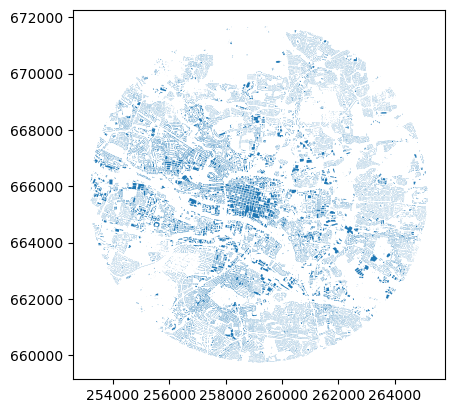

In [8]:
buildings.plot()

In [9]:
# buildings = momepy.preprocess(buildings.reset_index(), size=40,
#                               compactness=0.2, islands=True)

In [10]:
buildings

,geometry
0,"POLYGON ((253894.911 667992.009, 253894.504 66..."
3,"POLYGON ((257873.072 660535.923, 257874.349 66..."
5,"POLYGON ((260781.284 667382.518, 260777.467 66..."
10,"POLYGON ((258731.422 660456.589, 258733.748 66..."
30,"POLYGON ((254252.042 665895.371, 254225.829 66..."
...,...
286472,"POLYGON ((261598.050 664298.257, 261601.310 66..."
286507,"POLYGON ((263173.291 664689.249, 263174.015 66..."
286512,"POLYGON ((262230.343 670792.684, 262234.060 67..."
286519,"POLYGON ((262847.006 666028.488, 262849.217 66..."


In [11]:
# Check for invalid geometries
invalid_geometries = buildings[~buildings.geometry.is_valid]

# If there are invalid geometries, attempt to fix them
if not invalid_geometries.empty:
    print(f"Found {len(invalid_geometries)} invalid geometries. Attempting to fix...")
    buildings.geometry = buildings.geometry.buffer(0)

    # Recheck for invalid geometries
    still_invalid = buildings[~buildings.geometry.is_valid]
    if still_invalid.empty:
        print("All invalid geometries fixed.")
    else:
        print(f"Could not fix {len(still_invalid)} geometries.")
else:
    print("No invalid geometries found.")

Found 2 invalid geometries. Attempting to fix...
All invalid geometries fixed.


In [12]:
buildings['uID'] = momepy.unique_id(buildings)

In [13]:
water_bodies_boundaries = []

# Explode the GeoDataFrame into a GeoSeries of polygons and multipolygons
gs = water.explode()

# Convert each polygon into a MultiLineString
mls = gs.geometry.boundary

# Convert the MultiLineString into a DataFrame
water_bodies = gpd.GeoDataFrame({'geometry': mls})

for water_body in water_bodies.geometry:
    # Create a LineString object from the coordinates
    water_bodies_boundaries.append(water_body)

# # Create a GeoDataFrame of the water area boundaries
water_bodies_boundaries = gpd.GeoDataFrame({'geometry': water_bodies_boundaries}).reset_index(drop=True)

/tmp/ipykernel_12006/893087771.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gs = water.explode()


In [14]:
enclosures = momepy.enclosures(streets, limit=study_area, additional_barriers=[water_bodies_boundaries, rail])

/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as OSGB36 / British National Grid (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/momepy/elements.py:1025: FutureWarning: The `query_bulk()` method is deprecated and will be removed in GeoPandas 1.0. You can use the `query()` method instead.
  inp, res = enclosures.sindex.query_bulk(
/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as OSGB36 / British National Grid (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


In [15]:
num_chunks = ceil(len(buildings) / 1400000)

In [16]:
def split_bounds(bounds, num_chunks):
    minx, miny, maxx, maxy = bounds
    width = maxx - minx
    height = maxy - miny

    # Assuming a square grid for simplicity
    chunks_per_side = math.ceil(math.sqrt(num_chunks))
    chunk_width = width / chunks_per_side
    chunk_height = height / chunks_per_side

    chunks = []
    for i in range(chunks_per_side):
        for j in range(chunks_per_side):
            new_minx = minx + i * chunk_width
            new_miny = miny + j * chunk_height
            new_maxx = new_minx + chunk_width
            new_maxy = new_miny + chunk_height

            # Create a new bounding box (as a shapely box) for each chunk
            chunk_bounds = box(new_minx, new_miny, new_maxx, new_maxy)
            chunks.append(chunk_bounds)

    return gpd.GeoSeries(chunks)

# Example usage
chunks = split_bounds(enclosures.total_bounds, num_chunks)

In [17]:
chunks = gpd.GeoDataFrame(geometry = chunks)
chunks["chunk_ID"] = range(len(chunks))
enclosures["centroid"] = enclosures.centroid
enclosures = enclosures.sjoin(chunks, how="left")
enclosures = enclosures[["geometry", "chunk_ID", "eID"]]

/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geodataframe.py:2189: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


In [18]:
chunks

,geometry,chunk_ID
0,"POLYGON ((265517.761 659551.760, 265517.761 67...",0


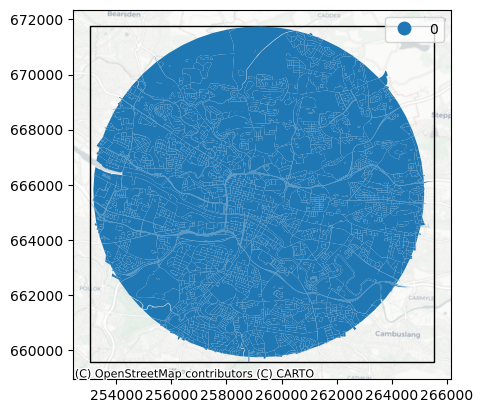

In [19]:
# Plotting each chunk
fig, ax = plt.subplots()
chunks.plot(ax=ax, edgecolor='black', facecolor='none')
enclosures.plot(ax=ax, column='chunk_ID', categorical=True, legend=True)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=buildings.crs)
plt.show()

In [20]:
buildings = buildings[["geometry"]].sjoin(enclosures, how="left")

In [21]:
buildings = buildings.dropna()[["geometry", "chunk_ID"]]
buildings["uID"] = range(len(buildings))
old_buildings = buildings
buildings = buildings.set_geometry('geometry')

In [22]:
buildings = buildings.to_crs(local_crs)
enclosures = enclosures.to_crs(local_crs)

In [23]:
tessellation = gpd.GeoDataFrame()

for index, chunk in tqdm(chunks.iterrows(), total= chunks.shape[0]):
    chunk_tessellation = momepy.Tessellation(buildings[buildings["chunk_ID"]==index], unique_id='uID', enclosures=enclosures[enclosures["chunk_ID"] == index], use_dask = True).tessellation
    tessellation = pd.concat([tessellation, chunk_tessellation])
    
tessellation_old = tessellation

  0%|          | 0/1 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [23]:
# tessellation.plot()

In [24]:
tessellation = tessellation_old

In [25]:
tessellation.to_parquet(f"../output/{place}/tessellation_p1_raw.pq")

In [26]:
# tessellation = gpd.read_parquet(f"../output/{place}/tessellation_p1_raw.pq")

In [27]:
tessellation=tessellation.sort_values(by='uID').reset_index(drop=True).dropna(subset=['uID'])

In [28]:
duplicate_gdf = tessellation[tessellation.duplicated('uID', keep=False)]

In [29]:
@delayed
def find_valid_from_multiples(gdf, building):
    gdf = gdf[gdf.intersects(building)]
        
    if gdf.shape[0] > 1:
        smallest_area = gdf.geometry.area.idxmin()
        return gdf.loc[[smallest_area]]
    return gdf

# Using a list comprehension for conciseness and efficiency
results = dask.compute([
    find_valid_from_multiples(duplicate_gdf[duplicate_gdf['uID'] == uid].reset_index(), buildings[buildings["uID"] == uid].geometry.iloc[0])
    for uid in duplicate_gdf["uID"].unique()
])

# Concatenate the results into a single GeoDataFrame
a = gpd.GeoDataFrame(pd.concat(results[0], ignore_index=True))
tessellation = gpd.GeoDataFrame(pd.concat([tessellation, a], ignore_index=True))


In [30]:
tessellation

,uID,geometry,eID,chunk_ID,index
0,0.0,"POLYGON ((253870.112 667991.936, 253870.333 66...",784,NaN,NaN
1,1.0,"POLYGON ((257804.191 660546.075, 257804.780 66...",1668,NaN,NaN
2,2.0,"POLYGON ((260775.818 667362.949, 260775.435 66...",868,NaN,NaN
3,3.0,"POLYGON ((258641.678 660399.969, 258641.110 66...",2489,NaN,NaN
4,4.0,"POLYGON ((254221.262 665840.607, 254221.462 66...",797,NaN,NaN
...,...,...,...,...,...
45789,25993.0,"POLYGON ((257966.298 665945.981, 257964.583 66...",252,NaN,26092.0
45790,25994.0,"POLYGON ((257966.298 665945.981, 257964.583 66...",252,NaN,26094.0
45791,25995.0,"POLYGON ((257966.298 665945.981, 257964.583 66...",252,NaN,26096.0
45792,41175.0,"POLYGON ((263465.372 662431.695, 263449.104 66...",4573,NaN,41278.0


In [31]:
tessellation = tessellation.drop("eID", axis = 1)

In [32]:
# Convert the 'uID' column of buildings to a set for efficient lookups
uIDs_buildings = set(buildings['uID'])

# Filter the tesellation GeoDataFrame to keep only rows with uID in buildings
tessellation = tessellation[tessellation['uID'].isin(uIDs_buildings)]


In [33]:
# Convert the 'uID' column of buildings to a set for efficient lookups
uIDs_tessellation = set(tessellation['uID'])

# Filter the tesellation GeoDataFrame to keep only rows with uID in buildings
buildings = buildings[buildings['uID'].isin(uIDs_tessellation)]


In [34]:
tessellation

,uID,geometry,chunk_ID,index
0,0.0,"POLYGON ((253870.112 667991.936, 253870.333 66...",NaN,NaN
1,1.0,"POLYGON ((257804.191 660546.075, 257804.780 66...",NaN,NaN
2,2.0,"POLYGON ((260775.818 667362.949, 260775.435 66...",NaN,NaN
3,3.0,"POLYGON ((258641.678 660399.969, 258641.110 66...",NaN,NaN
4,4.0,"POLYGON ((254221.262 665840.607, 254221.462 66...",NaN,NaN
...,...,...,...,...
45789,25993.0,"POLYGON ((257966.298 665945.981, 257964.583 66...",NaN,26092.0
45790,25994.0,"POLYGON ((257966.298 665945.981, 257964.583 66...",NaN,26094.0
45791,25995.0,"POLYGON ((257966.298 665945.981, 257964.583 66...",NaN,26096.0
45792,41175.0,"POLYGON ((263465.372 662431.695, 263449.104 66...",NaN,41278.0


In [35]:
tessellation = tessellation[["uID", "geometry"]]
buildings = buildings[["uID", "geometry"]]

In [36]:
tessellation[tessellation.duplicated('uID', keep=False)]

,uID,geometry
380,380.0,"POLYGON ((254325.973 666761.246, 254320.756 66..."
381,380.0,"POLYGON ((254292.573 666717.686, 254292.420 66..."
382,380.0,"POLYGON ((254334.370 666783.376, 254334.734 66..."
383,381.0,"POLYGON ((254292.573 666717.686, 254292.420 66..."
384,381.0,"POLYGON ((254325.973 666761.246, 254320.756 66..."
...,...,...
45789,25993.0,"POLYGON ((257966.298 665945.981, 257964.583 66..."
45790,25994.0,"POLYGON ((257966.298 665945.981, 257964.583 66..."
45791,25995.0,"POLYGON ((257966.298 665945.981, 257964.583 66..."
45792,41175.0,"POLYGON ((263465.372 662431.695, 263449.104 66..."


In [37]:
combined = tessellation.merge(buildings, on='uID', how='inner').reset_index()
combined["uID"] = range(len(combined))
combined

,index,uID,geometry_x,geometry_y
0,0,0,"POLYGON ((253870.112 667991.936, 253870.333 66...","POLYGON ((253894.911 667992.009, 253874.743 66..."
1,1,1,"POLYGON ((257804.191 660546.075, 257804.780 66...","POLYGON ((257873.072 660535.923, 257814.018 66..."
2,2,2,"POLYGON ((260775.818 667362.949, 260775.435 66...","POLYGON ((260781.284 667382.518, 260780.702 66..."
3,3,3,"POLYGON ((258641.678 660399.969, 258641.110 66...","POLYGON ((258731.422 660456.589, 258651.296 66..."
4,4,4,"POLYGON ((254221.262 665840.607, 254221.462 66...","POLYGON ((254252.042 665895.371, 254246.914 66..."
...,...,...,...,...
45789,45789,45789,"POLYGON ((261581.184 664295.868, 261580.742 66...","POLYGON ((261598.050 664298.257, 261581.647 66..."
45790,45790,45790,"POLYGON ((263164.852 664681.225, 263164.923 66...","POLYGON ((263173.291 664689.249, 263194.421 66..."
45791,45791,45791,"POLYGON ((262231.855 670784.099, 262231.798 67...","POLYGON ((262230.343 670792.684, 262237.303 67..."
45792,45792,45792,"POLYGON ((262813.592 666024.416, 262813.306 66...","POLYGON ((262847.006 666028.488, 262817.617 66..."


In [38]:
tessellation = gpd.GeoDataFrame(combined[["uID", "geometry_x"]], geometry='geometry_x')
tessellation = tessellation.rename(columns={'geometry_x': 'geometry'})

In [39]:
tessellation = tessellation.set_geometry("geometry", crs=local_crs)

In [40]:
buildings = gpd.GeoDataFrame(combined[["uID", "geometry_y"]], geometry='geometry_y')
buildings = buildings.rename(columns={'geometry_y': 'geometry'})

In [41]:
buildings = buildings.set_geometry("geometry", crs=local_crs)

In [42]:
tessellation.to_parquet(f"../output/{place}/tessellation_p2.pq")

In [43]:
buildings.to_parquet(f"../output/{place}/buildings_p2.pq")

In [44]:
streets.to_parquet(f"../output/{place}/streets_p2.pq")

In [45]:
# # Create a figure and axis

# # Plot streets in blue on the same axis
# streets.plot(ax=ax, color='blue')

# # Plot buildings in red on the same axis
# buildings.plot(ax=ax, color='red')

# tessellation.plot(ax = ax, color = 'green')

# # Show the plot
# plt.show()